#TRABAJO PRACTICO 2

**Integrantes**
 -  Davico, Cristian
 -  Speri, Sofia


**Objetivo:**

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las
cámaras digitales modernas. El video a procesar será: “focus_video.mov”.
1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image
Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
    1. Medición sobre todo el frame.
    2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.
    3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores
arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

  Para cada experimento se debe presentar :
    - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
    - Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames donde se detecta la condición de máximo enfoque.

2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera
automática.

In [7]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter
import os

## Definición de Métricas de Evaluación de Enfoque

#### Image Sharpness Measure for Blurred Images in Frequency Domain

In [8]:
def compute_IQM(img, threshold_denom):
  # Step 1: Compute F which is the Fourier Transform representation of image I
  frame_f = np.fft.fft2(img)

  # Step 2: Find Fc which is obtained by shifting the origin of F to centre.
  frame_fc = np.fft.fftshift(frame_f)

  # Step 3: Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I.
  frame_af = np.abs(frame_fc)

  # Step 4: Calculate M = max (AF) where M is the maximum value of the frequency component in F.
  frame_max = np.max(frame_af)

  # Step 5: Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000.
  pixels_above_threshold = frame_f > (frame_max/threshold_denom)
  th = np.sum(pixels_above_threshold)

  # Step 6: Calculate Image Quality measure (FM) from equation
  frame_fm = th / (frame_f.shape[0] * frame_f.shape[1])

  return frame_fm

#### Compute Gray Level (STA3)

Varianza de toda la imagen

In [9]:
def compute_gray_level_sta3(frame):
  return np.var(frame)

#### Armado de matrices de enfoque

In [10]:
#MATRIZ DE ENFOQUE
def mat_enfoque(frame,roi,n,m,alg):
   #Calculo matriz de roi
   frame_h = frame.shape[0]
   frame_w = frame.shape[1]
   roi_h = int(frame_h*(roi/100))
   roi_w = int(frame_w*(roi/100))

   espacio = 10
   roi_h_esp = (roi_h - (n - 1) * espacio)
   roi_w_esp = (roi_w - (m - 1) * espacio)



   # Verifico que la roi y el espacio no excedan los margenes
   if (frame_h > roi_h and frame_w > roi_w) and (roi_h_esp > n and roi_w_esp > m):

      #Centro la roi para obtener la región que me interesa de la imagen
      #Puntos de inicio de la ROI
      start_h = (frame_h // 2)-(roi_h//2)
      start_w = (frame_w // 2)-(roi_w//2)

      #Obtengo roi del frame
      frame_roi = frame[int(start_h) : int(start_h + roi_h), int(start_w) : int(start_w + roi_w)]

      #División de celdas de la matriz de enfoque y calculo de IQM por celda
      # enf_h = roi_h // n
      # enf_w = roi_w // m
      enf_h = roi_h_esp // n
      enf_w = roi_w_esp // m


      enfoque = np.zeros((n,m))

      #Coordenadas para luego graficar. Cada submatriz esta compuesta por [(x_start, y_start), (x_end, y_end)]
      coord_enf = np.empty((n, m), dtype=object)

      for i in range(n):
        for j in range(m):
          y_start = i * (enf_h + espacio)
          x_start = j * (enf_w + espacio)
          y_end = y_start + enf_h
          x_end = x_start + enf_w
          coord_enf[i, j] = ((start_w + x_start, start_h + y_start), (start_w + x_end, start_h + y_end))


          if alg == 2:
           enfoque[i][j] = compute_gray_level_sta3(frame_roi[y_start:y_end, x_start:x_end]) #GRAY VAR
          else:
           enfoque[i][j] = compute_IQM(frame_roi[y_start:y_end, x_start:x_end], 1000) #IQM



      return [enfoque, coord_enf]

#### Definición de umbral de enfoque

In [11]:
#UMBRAL DE ENFOQUE PARA DETECCIÓN
def umbral_enfoque(curva, valor):
  curva = np.array(curva)
  min = curva.min()
  max = curva.max()

  #si el máximo no es el doble que el mínimo, no lo tomo
  if (max < 2*min):
    return 0

  #Calculo umbral como el punt medio entre el valor máximo y el mínimo de la curva
  umbral = (min+max)/2

  if(valor >= umbral):
    return 1
  else:
    return 0


## 1 IQM

### 1.1. IQM sobre todo el frame del video

In [12]:
# Abre el video
video_path = 'focus_video.mov'
captura_video = cv2.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    video_fm = []
    enf_fm = []
    while True:
        ret, frame = captura_video.read()
        if ret:
            #Convertir a escala de grises
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            #Calcular IQM
            frame_fm = compute_IQM(frame_gris, 1000)
            video_fm.append(frame_fm)

            #Calculo máximo de enfoque. Guardo 1 si está enfocado, 0 si no
            if(len(video_fm)>=0):
                valor_umbral = umbral_enfoque(video_fm,frame_fm)
                enf_fm.append(valor_umbral)
            else:
                enf_fm.append(0)

        else:
            break

video_fm = np.array(video_fm)

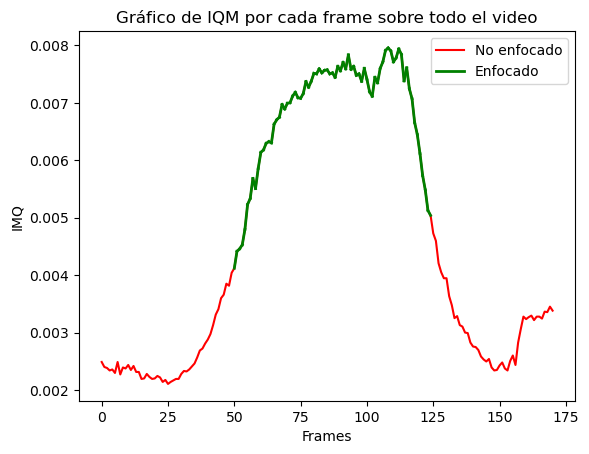

In [13]:
# Frames donde está enfocado
indices = [i for i, v in enumerate(enf_fm) if v == 1]

# Crear el gráfico
plt.plot(video_fm, color='red', label='No enfocado')

# Graficar los puntos enfocados con color verde
for i in indices:
    plt.plot([i-1, i], [video_fm[i-1], video_fm[i]], color='green', lw=2, label='Enfocado' if i == indices[0] else "")

# Agregar título y etiquetas de ejes
plt.title('Gráfico de IQM por cada frame sobre todo el video')
plt.xlabel('Frames')
plt.ylabel('IMQ')

# Agregar leyenda
plt.legend()

plt.show()

### 1.2 / 1.3 IQM con ROI y matrices de enfoque

1.2 Tomamos matriz de 1x1 para que haga el calculo sobre la ROI deseada

1.3 Tomamos matrices de 3x3, 5x5, 7x7

C:\Users\Sofi\AppData\Local\Temp\ipykernel_11368\1344321074.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


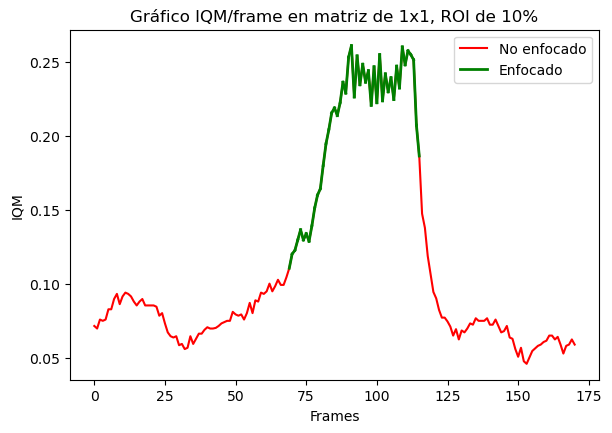

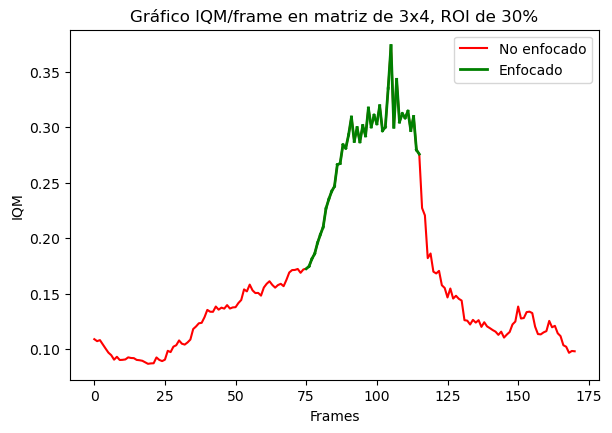

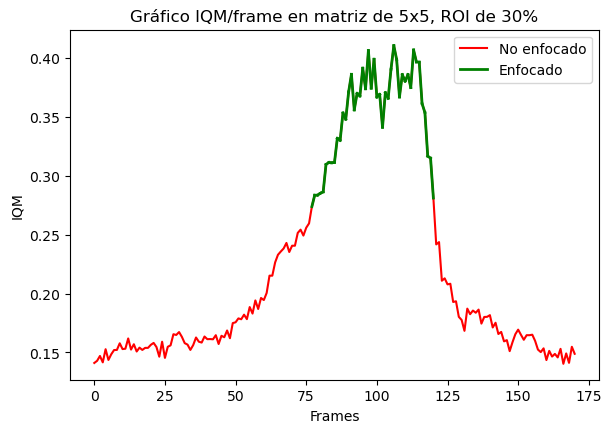

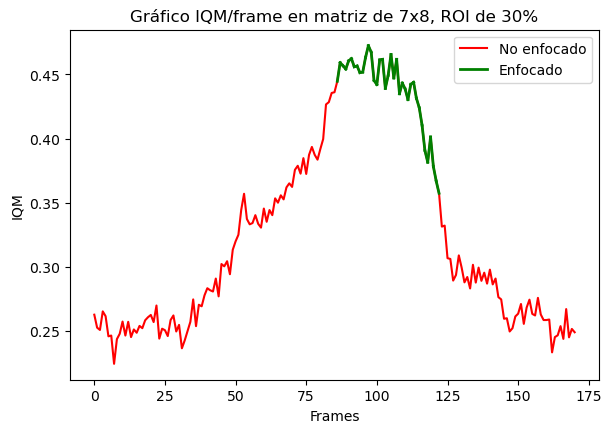

In [15]:
#from google.colab.patches import cv2_imshow

alg=1 #IQM
mat_dim_n = [1,3,5,7]
mat_dim_m = [1,4,5,8]
roi = [10,30,30,30]
subpl = [221,222,223,224]

for k in range(len(mat_dim_n)):

  # Abre el video
  video_path = 'focus_video.mov'
  captura_video = cv2.VideoCapture(video_path)

  if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
  else:
    video_fm = []
    enf_fm = []
    frames = []
    valor_umbral = 0
    while True:
        ret, frame = captura_video.read()
        if ret:
            #Convertir a escala de grises
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            #1.3 Calcular IQM para matriz de enfoque
            dim_n = mat_dim_n[k]
            dim_m = mat_dim_m[k]
            roi_k = roi[k]
            matriz1_result = mat_enfoque(frame_gris,roi_k,dim_n,dim_m,alg)
            matriz1 = matriz1_result[0]
            coord_matriz1 = matriz1_result[1]

            # Guarda valor de IQM para todo el experimento
            video_fm.append(np.mean(matriz1))

            #Calculo máximo de enfoque. Guardo 1 si está enfocado, 0 si no
            if(len(video_fm)>=0):
               # print(video_fm)
               # print(np.mean(matriz1))
                valor_umbral = umbral_enfoque(video_fm,np.mean(matriz1))
                enf_fm.append(valor_umbral)
            else:
                enf_fm.append(0)

            # Convertir la imagen de escala de grises a BGR
            frame_color = cv2.cvtColor(frame_gris, cv2.COLOR_GRAY2BGR)
            for i in range(coord_matriz1.shape[0]):
              for j in range(coord_matriz1.shape[1]):
                if valor_umbral == 1:
                  cv2.rectangle(frame_color, coord_matriz1[i][j][0], coord_matriz1[i][j][1], color=(0,255,0), thickness=2)
                else:
                  cv2.rectangle(frame_color, coord_matriz1[i][j][0], coord_matriz1[i][j][1], color=(0,0,255), thickness=2)
            frames.append(frame_color)
        else:
            break

  video_fm = np.array(video_fm)
  frames = np.array(frames)

  ## GRAFICO DE CURVA CON DETECCION DE ENFOQUE
  fig = plt.figure(figsize=(15, 10))
  ax1=plt.subplot(subpl[k])
  # Frames donde está enfocado
  indices = [i for i, v in enumerate(enf_fm) if v == 1]

  # Crear el gráfico
  ax1.plot(video_fm, color='red', label='No enfocado')

  # Graficar los puntos enfocados con color verde
  for i in indices:
    ax1.plot([i-1, i], [video_fm[i-1], video_fm[i]], color='green', lw=2, label='Enfocado' if i == indices[0] else "")

  # Título y etiquetas de ejes
  ax1.set_title(f"Gráfico IQM/frame en matriz de {dim_n}x{dim_m}, ROI de {roi_k}%")
  ax1.set_ylabel('IQM')
  ax1.set_xlabel('Frames')
  ax1.set_label('IQM')

  # Agregar leyenda
  ax1.legend()

  fig.show()

  ## EXPORTACION DEL VIDEO

  height, width, layers = frames[0].shape
  size = (width, height)

  out = cv2.VideoWriter(f'output_video_IMQ_{dim_n}x{dim_m}.avi', cv2.VideoWriter_fourcc(*'DIVX'), 30, size)

  #Cargo video con frames
  for frame in frames:
     out.write(frame)

  out.release()



## 2 ALGORITMO ANEXO (STA3)

### 2.1. STA3 sobre todo el video

In [16]:
# Abre el video
video_path = 'focus_video.mov'
captura_video = cv2.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    video_fm = []
    while True:
        ret, frame = captura_video.read()
        if ret:
            #Convertir a escala de grises
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            #Calcular STA3
            frame_fm = compute_gray_level_sta3(frame_gris)
            video_fm.append(frame_fm)


              #Calculo máximo de enfoque. Guardo 1 si está enfocado, 0 si no
            if(len(video_fm)>=0):
                valor_umbral = umbral_enfoque(video_fm,frame_fm)
                enf_fm.append(valor_umbral)
            else:
                enf_fm.append(0)
        else:
            break


video_fm = np.array(video_fm)

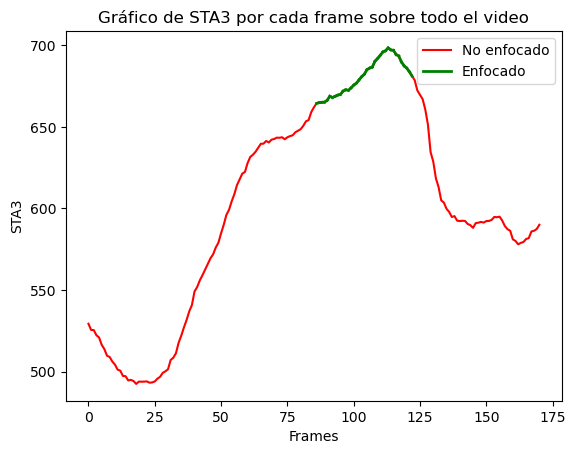

In [17]:
# Frames donde está enfocado
indices = [i for i, v in enumerate(enf_fm) if v == 1]

# Crear el gráfico
plt.plot(video_fm, color='red', label='No enfocado')

# Graficar los puntos enfocados con color verde
for i in indices:
    plt.plot([i-1, i], [video_fm[i-1], video_fm[i]], color='green', lw=2, label='Enfocado' if i == indices[0] else "")

# Agregar título y etiquetas de ejes
plt.title('Gráfico de STA3 por cada frame sobre todo el video')
plt.xlabel('Frames')
plt.ylabel('STA3')

# Agregar leyenda
plt.legend()

plt.show()

### 2.2 / 2.3 STA3 con ROI y matrices de enfoque

1.2 Tomamos matriz de 1x1 para que haga el calculo sobre la ROI deseada

1.3 Tomamos matrices de 3x3, 5x5, 7x7

C:\Users\Sofi\AppData\Local\Temp\ipykernel_11368\3316329457.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


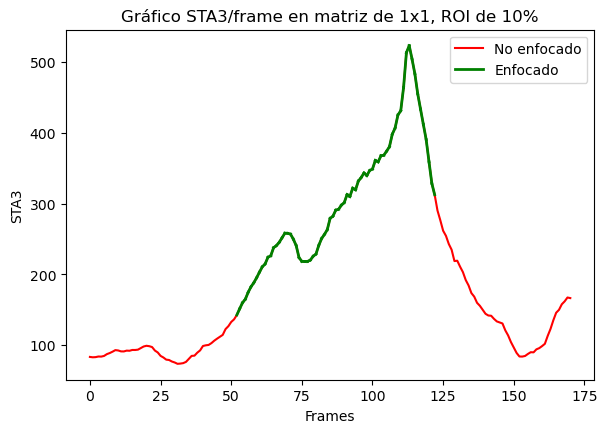

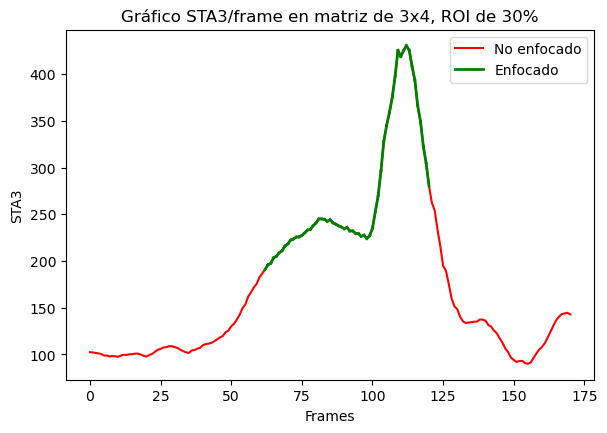

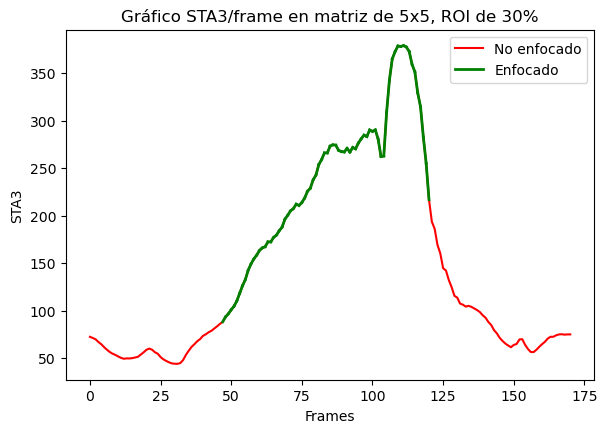

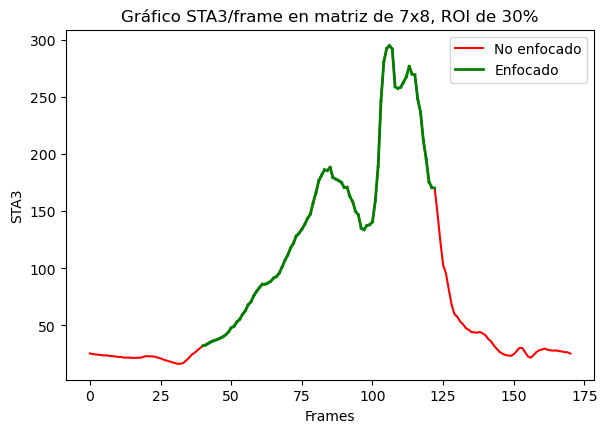

In [18]:
#from google.colab.patches import cv2_imshow

alg=2 #STA3
mat_dim_n = [1,3,5,7]
mat_dim_m = [1,4,5,8]
roi = [10,30,30,30]
subpl = [221,222,223,224]

for k in range(len(mat_dim_n)):

  # Abre el video
  video_path = 'focus_video.mov'
  captura_video = cv2.VideoCapture(video_path)

  if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
  else:
    video_fm = []
    enf_fm = []
    frames = []
    valor_umbral = 0
    while True:
        ret, frame = captura_video.read()
        if ret:
            #Convertir a escala de grises
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            #1.3 Calcular IQM para matriz de enfoque
            dim_n = mat_dim_n[k]
            dim_m = mat_dim_m[k]
            roi_k = roi[k]
            matriz1_result = mat_enfoque(frame_gris,roi_k,dim_n,dim_m,alg)
            matriz1 = matriz1_result[0]
            coord_matriz1 = matriz1_result[1]

            # Guarda valor de IQM para todo el experimento
            video_fm.append(np.mean(matriz1))

            #Calculo máximo de enfoque. Guardo 1 si está enfocado, 0 si no
            if(len(video_fm)>=0):
               # print(video_fm)
               # print(np.mean(matriz1))
                valor_umbral = umbral_enfoque(video_fm,np.mean(matriz1))
                enf_fm.append(valor_umbral)
            else:
                enf_fm.append(0)

            # Convertir la imagen de escala de grises a BGR
            frame_color = cv2.cvtColor(frame_gris, cv2.COLOR_GRAY2BGR)
            for i in range(coord_matriz1.shape[0]):
              for j in range(coord_matriz1.shape[1]):
                if valor_umbral == 1:
                  cv2.rectangle(frame_color, coord_matriz1[i][j][0], coord_matriz1[i][j][1], color=(0,255,0), thickness=2)
                else:
                  cv2.rectangle(frame_color, coord_matriz1[i][j][0], coord_matriz1[i][j][1], color=(0,0,255), thickness=2)
            frames.append(frame_color)
        else:
            break

  video_fm = np.array(video_fm)
  frames = np.array(frames)

  ## GRAFICO DE CURVA CON DETECCION DE ENFOQUE
  fig = plt.figure(figsize=(15, 10))
  ax1=plt.subplot(subpl[k])
  # Frames donde está enfocado
  indices = [i for i, v in enumerate(enf_fm) if v == 1]

  # Crear el gráfico
  ax1.plot(video_fm, color='red', label='No enfocado')

  # Graficar los puntos enfocados con color verde
  for i in indices:
    ax1.plot([i-1, i], [video_fm[i-1], video_fm[i]], color='green', lw=2, label='Enfocado' if i == indices[0] else "")

  # Título y etiquetas de ejes
  ax1.set_title(f"Gráfico STA3/frame en matriz de {dim_n}x{dim_m}, ROI de {roi_k}%")
  ax1.set_xlabel('Frames')
  ax1.set_ylabel('STA3')
  ax1.set_label('STA3')

  # Agregar leyenda
  ax1.legend()

  fig.show()

  ## EXPORTACION DEL VIDEO

  height, width, layers = frames[0].shape
  size = (width, height)

  out = cv2.VideoWriter(f'output_video_STA3_{dim_n}x{dim_m}.avi', cv2.VideoWriter_fourcc(*'DIVX'), 30, size)

  #Cargo video con frames
  for frame in frames:
    out.write(frame)

  out.release()

